In [11]:
from collections import defaultdict
import awkward as ak
import numba
import numpy as np
import pandas as pd
import h5py
import vector
vector.register_numba()
vector.register_awkward()

import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#import mplhep as hep
#hep.style.use(hep.style.ROOT)

In [6]:
prefix="/run/user/1000/gvfs/sftp:host=lxplus.cern.ch,user=mmalucch/"
filename_test = prefix+"/eos/home-m/mmalucch/spanet_inputs/output_JetGoodHiggs_test.h5"
filename_test="/work/mmalucch/out_hh4b/hh4b_btag_in_presel_0pad/output_JetGoodHiggs_test.h5"
filename_test = prefix+"/eos/home-m/mmalucch/spanet_inputs/zero_padding/output_JetGoodHiggs_test.h5"
filename_pred = prefix+"/eos/home-r/ramellar/prediction.h5"
filename_pred = "/home/matteo/Downloads/prediction.h5"
filename_pred="/work/mmalucch/out_hh4b/hh4b_btag_in_presel_0pad/output_JetGoodHiggs_test.h5"
filename_test = prefix+"/eos/home-m/mmalucch/spanet_inputs/2b_data/output_JetGoodHiggs_test.h5"
filename_pred = prefix+"/eos/home-m/mmalucch/spanet_inputs/2b_data/output_JetGoodHiggs_test.h5"
filename_pred1 = prefix+"/afs/cern.ch/user/m/mmalucch/public/out_prediction_files/out_spanet_prediction_data_ev5jets_training5jet_ptreg_ATLAS.h5"
filename_pred2 = prefix+"/afs/cern.ch/user/m/mmalucch/public/out_prediction_files/out_spanet_prediction_5jets_ptreg_nobtag_ATLAS.h5"

df_test = h5py.File(filename_test,'r')
df_pred1 = h5py.File(filename_pred1,'r')
df_pred2 = h5py.File(filename_pred2,'r')

In [7]:
print(df_pred1["TARGETS"]["h2"]["assignment_probability"][()])
print(df_pred1["TARGETS"]["h1"]["assignment_probability"][()])

print(df_pred2["TARGETS"]["h2"]["assignment_probability"][()])
print(df_pred2["TARGETS"]["h1"]["assignment_probability"][()])


[0.7799347  0.24838412 0.9772205  ... 0.17685999 0.6390556  0.95590156]
[2.5302640e-01 9.7907144e-01 1.0196682e-02 ... 6.3568050e-01 9.9980807e-01
 1.0424928e-06]
[0.99533105 0.999995   0.9985881  ... 0.97980636 0.99999756 0.9980625 ]
[0.5675326  0.9994379  0.9998037  ... 0.99999005 0.9999594  0.9961406 ]


In [15]:
sum1=(df_pred1["TARGETS"]["h2"]["assignment_probability"][()]+df_pred1["TARGETS"]["h1"]["assignment_probability"][()])/2
sum2=(df_pred2["TARGETS"]["h2"]["assignment_probability"][()]+df_pred2["TARGETS"]["h1"]["assignment_probability"][()])/2

print(sum1)
print(sum2)


[0.51648057 0.6137278  0.49370858 ... 0.40627024 0.81943184 0.4779513 ]
[0.7814318  0.99971646 0.99919593 ... 0.9898982  0.9999785  0.99710155]


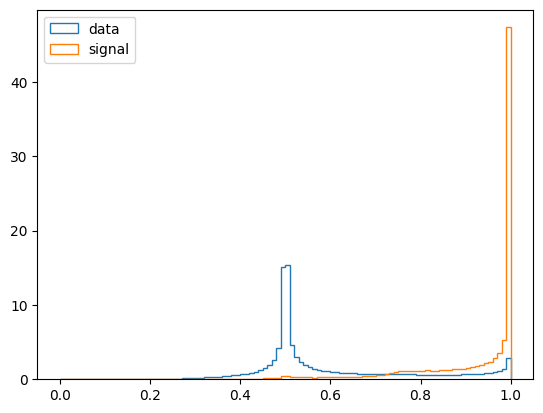

In [16]:
plt.hist(sum1,bins=100,range=(0,1),histtype='step',label="data", density=True)
plt.hist(sum2,bins=100,range=(0,1),histtype='step',label="signal", density=True)
plt.legend()
plt.show()


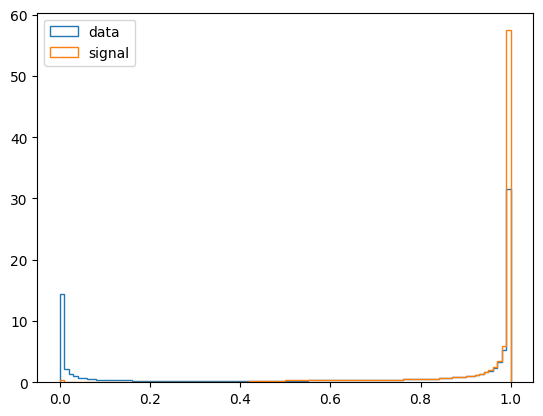

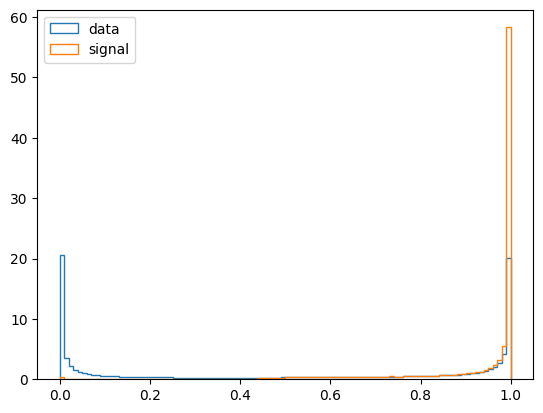

In [21]:
h1_data=df_pred1["TARGETS"]["h1"]["assignment_probability"][()]
h2_data=df_pred1["TARGETS"]["h2"]["assignment_probability"][()]
h1_sig=df_pred2["TARGETS"]["h1"]["assignment_probability"][()]
h2_sig=df_pred2["TARGETS"]["h2"]["assignment_probability"][()]

plt.hist(h1_data,bins=100,range=(0,1),histtype='step',label="data", density=True)
plt.hist(h1_sig,bins=100,range=(0,1),histtype='step',label="signal", density=True)
plt.legend()
plt.show()

plt.hist(h2_data,bins=100,range=(0,1),histtype='step',label="data", density=True)
plt.hist(h2_sig,bins=100,range=(0,1),histtype='step',label="signal", density=True)
plt.legend()
plt.show()


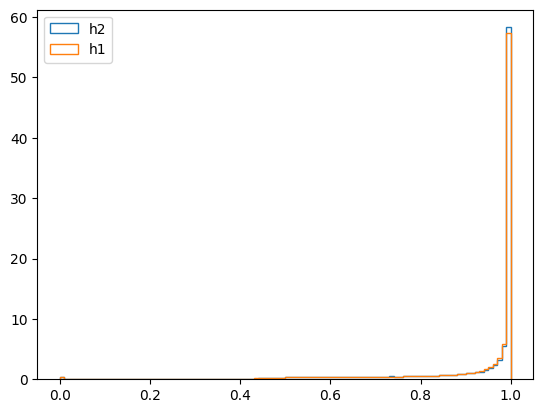

In [22]:
plt.hist(h2_sig,bins=100,range=(0,1),histtype='step',label="h2", density=True)
plt.hist(h1_sig,bins=100,range=(0,1),histtype='step',label="h1", density=True)
plt.legend()
plt.show()

In [17]:
df_test["INPUTS"]["FifthJet"]["btag"][()]


array([6.4849854e-03, 9.9990000e+03, 9.9990000e+03, ..., 5.4244995e-03,
       9.9990000e+03, 9.9990000e+03], dtype=float32)

In [18]:
df_pred["TARGETS"]["h1"].keys()

<KeysViewHDF5 ['assignment_probability', 'b1', 'b2', 'detection_probability', 'marginal_probability']>

## Compute the jet assignment efficiency
We extract the predicted and true indices for the individual quarks.
Jets are correctly assigned when the predicted jet index is equal to the true index. We can compute the efficiency as the ratio of the correctly assigned jets over the total number of jets.

In [19]:
idx_b1_pred = df_pred["TARGETS"]["h1"]["b1"][()]
idx_b2_pred = df_pred["TARGETS"]["h1"]["b2"][()]
idx_b1_pred

array([0, 0, 2, ..., 0, 1, 2])

In [20]:
idx_b1_true = df_test["TARGETS"]["h1"]["b1"][()]
idx_b2_true = df_test["TARGETS"]["h1"]["b2"][()]
idx_b1_true

KeyboardInterrupt: 

In [ ]:
idx_h1_pred = ak.concatenate((ak.unflatten(idx_b1_pred, ak.ones_like(idx_b1_pred)), ak.unflatten(idx_b2_pred, ak.ones_like(idx_b2_pred))), axis=1)
idx_h1_true = ak.concatenate((ak.unflatten(idx_b1_true, ak.ones_like(idx_b1_true)), ak.unflatten(idx_b2_true, ak.ones_like(idx_b2_true))), axis=1)
idx_h1_pred

<Array [[0, 0], [0, 0], ... [0, 0], [0, 0]] type='1383920 * var * int64'>

In [ ]:
print(idx_h1_pred)
print(idx_h1_true)

[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], ... [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], ... [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]


In [ ]:
idx_b3_pred = df_pred["TARGETS"]["h2"]["b3"][()]
idx_b4_pred = df_pred["TARGETS"]["h2"]["b4"][()]
idx_b3_true = df_test["TARGETS"]["h2"]["b3"][()]
idx_b4_true = df_test["TARGETS"]["h2"]["b4"][()]

idx_h2_pred = ak.concatenate((ak.unflatten(idx_b3_pred, ak.ones_like(idx_b3_pred)), ak.unflatten(idx_b4_pred, ak.ones_like(idx_b4_pred))), axis=1)
idx_h2_true = ak.concatenate((ak.unflatten(idx_b3_true, ak.ones_like(idx_b3_true)), ak.unflatten(idx_b4_true, ak.ones_like(idx_b4_true))), axis=1)
print(idx_h2_pred)
print(idx_h2_true)

[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], ... [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], ... [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]


In [ ]:
# order the true array in increasing order
idx_h1_true_order = ak.sort(idx_h1_true, axis=1)
idx_h1_true_order = idx_h1_true
print(idx_h1_true)
print(idx_h1_true_order)
print(ak.sum(idx_h1_true[:,0]>idx_h1_true[:,1]))
print(ak.sum(idx_h1_true_order[:,0]>idx_h1_true_order[:,1]))

print(idx_h1_true[idx_h1_true[:,0]>idx_h1_true[:,1]])
print(len(idx_h1_true[idx_h1_true[:,0]>idx_h1_true[:,1]]))

print(idx_h1_true_order)

print(idx_h1_true_order[idx_h1_true_order[:,1]==-1])
print(ak.num(idx_h1_true_order[(idx_h1_true[:,1]==-1) & (idx_h1_true[:,0]!=-1)], axis=0))
print(len(idx_h1_true[(idx_h1_true[:,1]==-1) & (idx_h1_true[:,0]!=-1)]))

idx_h2_true_order=ak.sort(idx_h2_true, axis=1)
idx_h2_true_order = idx_h2_true


[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], ... [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], ... [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
0
0
[]
0
[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], ... [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
[]
0
0


In [ ]:
# concatenate the two arrays for h1 and h2 adding another axis
idx_true = ak.concatenate((ak.unflatten(idx_h1_true_order, ak.ones_like(idx_h1_true_order[:,0])), ak.unflatten(idx_h2_true_order, ak.ones_like(idx_h2_true_order[:,0]))), axis=1)
print(idx_true[2:5])

idx_pred = ak.concatenate((ak.unflatten(idx_h1_pred, ak.ones_like(idx_h1_pred[:,0])), ak.unflatten(idx_h2_pred, ak.ones_like(idx_h2_pred[:,0]))), axis=1)
print(idx_pred[2:5])

# if an event has a -1 in the true array, remove it
mask_fully_matched = ak.all(ak.all(idx_true>=0, axis=-1), axis=-1)
print(mask_fully_matched)

idx_true_fully_matched = idx_true[mask_fully_matched]
idx_pred_fully_matched = idx_pred[mask_fully_matched]
print(idx_true_fully_matched[2:5])
print(idx_pred_fully_matched[2:5])

print(ak.sum(idx_true_fully_matched[idx_true_fully_matched[:,:,0]>idx_true_fully_matched[:,:,1]]))

print(len(idx_true_fully_matched))
print(len(idx_true_fully_matched)/len(idx_true))

# idx_true_fully_matched=ak.to_numpy  (idx_true_fully_matched)
# idx_pred_fully_matched=ak.to_numpy  (idx_pred_fully_matched)


[[[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]]]
[[[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]]]
[True, True, True, True, True, True, True, ... True, True, True, True, True, True]
[[[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]]]
[[[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]]]
0
1383920
1.0


In [ ]:
# # CHECK IF THE TWO ARRAYS ARE EQUAL and if you swap the columns
# matched_events =[]
# for i in range(len(idx_true_fully_matched)):
#     arr_true = idx_true_fully_matched[i]
#     arr_pred = idx_pred_fully_matched[i]
#     if ak.all(arr_true[0]==arr_pred[0]) or ak.all(arr_true[0]==arr_pred[1]):
#         matched_events.append(i)

# print(len(matched_events))


In [ ]:
# print("eff: ", len(matched_events)/len(idx_true_fully_matched))

In [ ]:
correctly_fully_matched = (
    ak.all(idx_true_fully_matched[:, 0] == idx_pred_fully_matched[:, 0], axis=1)
    | ak.all(idx_true_fully_matched[:, 0] == idx_pred_fully_matched[:, 1], axis=1)
    | ak.all(idx_true_fully_matched[:, 1] == idx_pred_fully_matched[:, 0], axis=1)
    | ak.all(idx_true_fully_matched[:, 1] == idx_pred_fully_matched[:, 1], axis=1)
)
print(ak.sum(correctly_fully_matched) / len(idx_true_fully_matched))

1.0


In [ ]:
mask_1h = ak.sum(ak.any(idx_true == -1, axis=-1), axis=-1) == 1
print(mask_1h)
print(idx_true)
idx_true_partially_matched_1h = idx_true[mask_1h]
idx_pred_partially_matched_1h = idx_pred[mask_1h]
print(idx_true_partially_matched_1h[2:5])
print(idx_pred_partially_matched_1h[2:5])
print(len(idx_true_partially_matched_1h))
print(len(idx_true_partially_matched_1h) / len(idx_true))

correctly_partially_matched_1h = (
    ak.all(
        idx_true_partially_matched_1h[:, 0] == idx_pred_partially_matched_1h[:, 0],
        axis=1,
    )
    | ak.all(
        idx_true_partially_matched_1h[:, 0] == idx_pred_partially_matched_1h[:, 1],
        axis=1,
    )
    | ak.all(
        idx_true_partially_matched_1h[:, 1] == idx_pred_partially_matched_1h[:, 0],
        axis=1,
    )
    | ak.all(
        idx_true_partially_matched_1h[:, 1] == idx_pred_partially_matched_1h[:, 1],
        axis=1,
    )
)
print(correctly_partially_matched_1h[2:5])
print(ak.sum(correctly_partially_matched_1h) / len(idx_true_partially_matched_1h))

[False, False, False, False, False, False, ... False, False, False, False, False]
[[[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, ... [[0, 0], [0, 0]], [[0, 0], [0, 0]]]
[]
[]
0
0.0
[]
nan


/tmp/ipykernel_16072/3289796845.py:30: RuntimeWarning: invalid value encountered in long_scalars
  print(ak.sum(correctly_partially_matched_1h) / len(idx_true_partially_matched_1h))


In [ ]:
mask_0h=ak.sum(ak.any(idx_true==-1, axis=-1), axis=-1)==2
print(mask_0h)
print(idx_true)
idx_true_unmatched=idx_true[mask_0h]
idx_pred_unmatched=idx_pred[mask_0h]
print(idx_true_unmatched[2:5])
print(idx_pred_unmatched[2:5])
print(len(idx_true_unmatched))
print(len(idx_true_unmatched)/len(idx_true))


[False, False, False, False, False, False, ... False, False, False, False, False]
[[[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, ... [[0, 0], [0, 0]], [[0, 0], [0, 0]]]
[]
[]
0
0.0


In [ ]:
print(len(idx_true_fully_matched)+len(idx_true_partially_matched_1h)+len(idx_true_unmatched))
print(len(idx_true))

1383920
1383920


In [ ]:
# summary
frac_fully_matched = len(idx_true_fully_matched) / len(idx_true)
frac_partially_matched_1h = len(idx_true_partially_matched_1h) / len(idx_true)
frac_unmatched = len(idx_true_unmatched) / len(idx_true)
eff_fully_matched = ak.sum(correctly_fully_matched) / len(idx_true_fully_matched)
eff_partially_matched_1h = ak.sum(correctly_partially_matched_1h) / len(idx_true_partially_matched_1h)
eff_unmatched = len(idx_true_unmatched) / len(idx_true)

print(
    f"Fraction of events fully matched: {frac_fully_matched:.3f}\n"
    f"Fraction of events partially matched (1h): {frac_partially_matched_1h:.3f}\n"
    f"Fraction of events unmatched: {frac_unmatched:.3f}\n"
    f"Purity fully matched: {eff_fully_matched:.3f}\n"
    f"Purity partially matched (1h): {eff_partially_matched_1h:.3f}\n"
    f"Purity unmatched: {eff_unmatched:.3f}"
)

Fraction of events fully matched: 1.000
Fraction of events partially matched (1h): 0.000
Fraction of events unmatched: 0.000
Purity fully matched: 1.000
Purity partially matched (1h): nan
Purity unmatched: 0.000


/tmp/ipykernel_16072/587339941.py:6: RuntimeWarning: invalid value encountered in long_scalars
  eff_partially_matched_1h = ak.sum(correctly_partially_matched_1h) / len(idx_true_partially_matched_1h)
